Algorithm implemented :   
Cluster based anomaly detection (K-mean)   
Repartition of data into categories then Gaussian/Elliptic Enveloppe on each categories separately   
Markov Chain    
Isolation Forest    
One class SVM     
RNN (comparison between prediction and reality)    
https://www.kaggle.com/victorambonati/unsupervised-anomaly-detection    

In [46]:
#%matplotlib notebook

import pandas as pd
import numpy as np

import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
#from pyemma import msm # not available on Kaggle Kernel
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

In [47]:
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        #distance.set_value(i, np.linalg.norm(Xa-Xb))
        distance.at[i] = np.linalg.norm(Xa-Xb)
    return distance

# train markov model to get transition matrix
def getTransitionMatrix (df):
    df = np.array(df)
    model = msm.estimate_markov_model(df, 1)
    return model.transition_matrix

def markovAnomaly(df, windows_size, threshold):
    transition_matrix = getTransitionMatrix(df)
    real_threshold = threshold**windows_size
    df_anomaly = []
    for j in range(0, len(df)):
        if (j < windows_size):
            df_anomaly.append(0)
        else:
            sequence = df[j-windows_size:j]
            sequence = sequence.reset_index(drop=True)
            df_anomaly.append(anomalyElement(sequence, real_threshold, transition_matrix))
    return df_anomaly

In [48]:
#df = pd.read_csv('../csv_data/m_data_fromNow.csv', usecols=['date', 'time', 'cpu'])
#df.head()

In [49]:
#df['timestamp'] = df[df.columns[0:2]]. apply(
#    lambda x: ' '.join(x.dropna().astype(str)),
#    axis=1)
#df.head()

In [50]:
## CSV : convert=> UTC -> [DATE time] cpu_value->[cpu]
df = pd.read_csv('../cto_k8s/m_data_10.11.1.80:9091.csv', usecols=['time', 'cpu_value'])
df.rename(columns={'cpu_value':'cpu'}, inplace=True)

df['timestamp'] = pd.to_datetime(df.time, unit='s')
df['cpu'] = df['cpu'].fillna(df['cpu'].mean())

In [51]:
df = df[['timestamp', 'cpu']]
df.head()

,timestamp,cpu
0,2020-08-04 00:00:00,0.565333
1,2020-08-04 00:10:00,0.571564
2,2020-08-04 00:20:00,0.543800
3,2020-08-04 00:30:00,0.534930
4,2020-08-04 00:40:00,0.569663


In [52]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6349 entries, 0 to 6348
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  6349 non-null   datetime64[ns]
 1   cpu        6349 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 99.3 KB
None


In [53]:
print(df['timestamp'].head())

0   2020-08-04 00:00:00
1   2020-08-04 00:10:00
2   2020-08-04 00:20:00
3   2020-08-04 00:30:00
4   2020-08-04 00:40:00
Name: timestamp, dtype: datetime64[ns]


In [54]:
print(df['cpu'].mean())

1.7536843113655571


<AxesSubplot:xlabel='timestamp'>

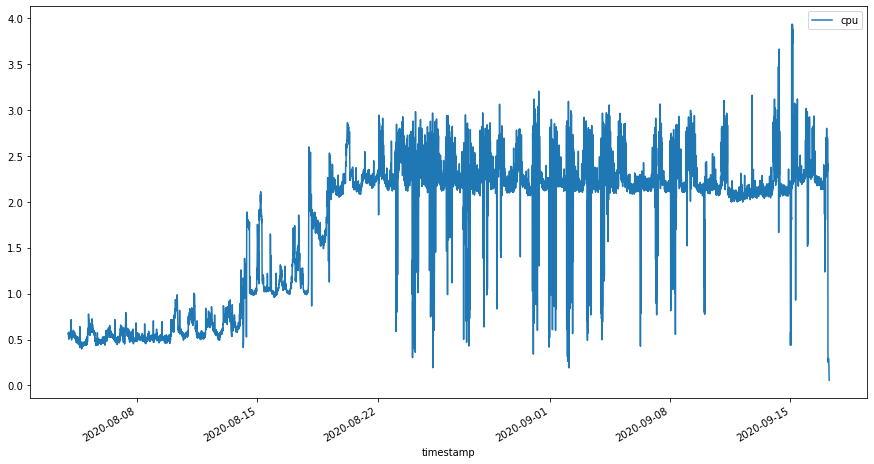

In [55]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.plot(x = 'timestamp', y='cpu')

In [56]:
df['hours'] = df['timestamp'].dt.hour
df['daylight'] = ((df['hours'] >= 8) & (df['hours'] <= 19)).astype(int)
df.head(40)

,timestamp,cpu,hours,daylight
0,2020-08-04 00:00:00,0.565333,0,0
1,2020-08-04 00:10:00,0.571564,0,0
2,2020-08-04 00:20:00,0.543800,0,0
3,2020-08-04 00:30:00,0.534930,0,0
4,2020-08-04 00:40:00,0.569663,0,0
5,2020-08-04 00:50:00,0.503467,0,0
6,2020-08-04 01:00:00,0.579867,1,0
7,2020-08-04 01:10:00,0.574533,1,0
8,2020-08-04 01:20:00,0.575000,1,0
9,2020-08-04 01:30:00,0.569973,1,0


In [57]:
s = pd.date_range('2020-08-04', '2020-08-31').to_series()
s.dt.dayofweek

2020-08-04    1
2020-08-05    2
2020-08-06    3
2020-08-07    4
2020-08-08    5
2020-08-09    6
2020-08-10    0
2020-08-11    1
2020-08-12    2
2020-08-13    3
2020-08-14    4
2020-08-15    5
2020-08-16    6
2020-08-17    0
2020-08-18    1
2020-08-19    2
2020-08-20    3
2020-08-21    4
2020-08-22    5
2020-08-23    6
2020-08-24    0
2020-08-25    1
2020-08-26    2
2020-08-27    3
2020-08-28    4
2020-08-29    5
2020-08-30    6
2020-08-31    0
Freq: D, dtype: int64

In [58]:
df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)
outliers_fraction = 0.01


In [59]:
df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

In [60]:
df['categories'] = df['WeekDay']*2 + df['daylight']


a = df.loc[df['categories'] == 0, 'cpu']
b = df.loc[df['categories'] == 1, 'cpu']
c = df.loc[df['categories'] == 2, 'cpu']
d = df.loc[df['categories'] == 3, 'cpu']


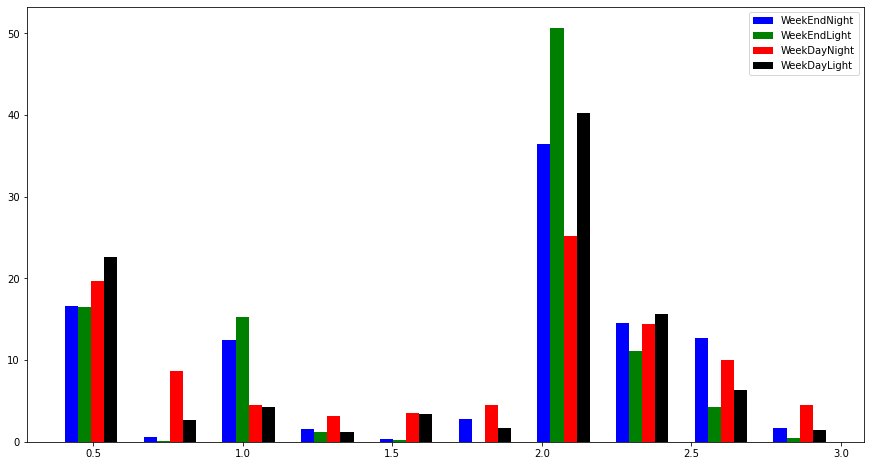

In [61]:
fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)

width = (a_bins[1] - a_bins[0])/6

ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='WeekEndNight')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='WeekEndLight')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='WeekDayNight')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='black', label ='WeekDayLight')

plt.rcParams['figure.figsize'] = [10, 5]
plt.legend()


In [62]:
# Take useful feature and standardize them
data = df[['cpu', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# reduce to 2 importants features
pca = PCA(n_components=2)
data = pca.fit_transform(data)
# standardize these 2 new features
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

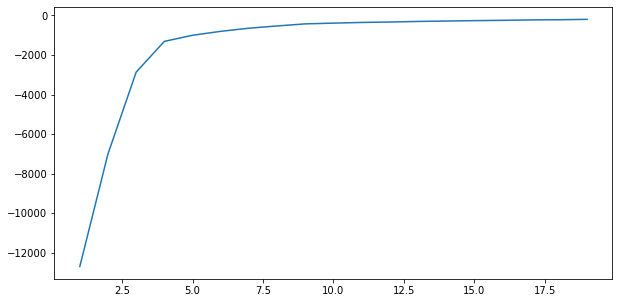

In [63]:
# calculate with different number of centroids to see the loss plot (elbow method)
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)

In [64]:
# Not clear for me, I choose 15 centroids arbitrarily and add these data to the central dataframe
df['cluster'] = kmeans[14].predict(data)
df['principal_feature1'] = data[0]
df['principal_feature2'] = data[1]
df['cluster'].value_counts()

8     626
4     576
0     576
5     536
1     526
3     448
7     424
11    373
12    368
10    344
13    343
14    320
9     310
6     297
2     282
Name: cluster, dtype: int64

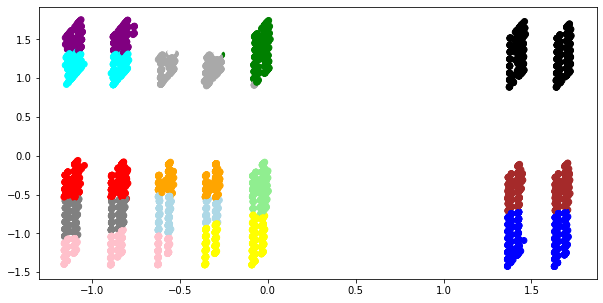

In [65]:
#plot the different clusters with the 2 main features
fig, ax = plt.subplots()
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow', 8:'brown', 9:'purple', 10:'white', 11: 'grey', 12:'lightblue', 13:'lightgreen', 14: 'darkgrey'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["cluster"].apply(lambda x: colors[x]))
plt.show()

In [66]:
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(data, kmeans[14])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
# anomaly21 contain the anomaly result of method 2.1 Cluster (0:normal, 1:anomaly) 
df['anomaly21'] = (distance >= threshold).astype(int)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


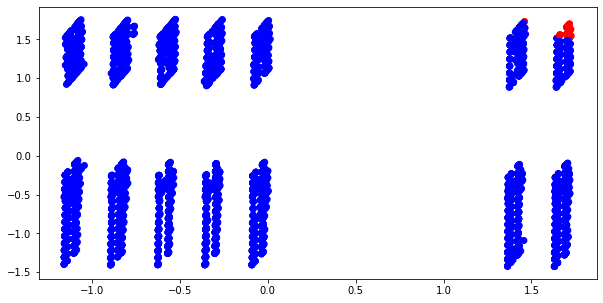

In [67]:
fig, ax = plt.subplots()
color = {0:'blue', 1:'red'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["anomaly21"].apply(lambda x: color[x]))
plt.show()

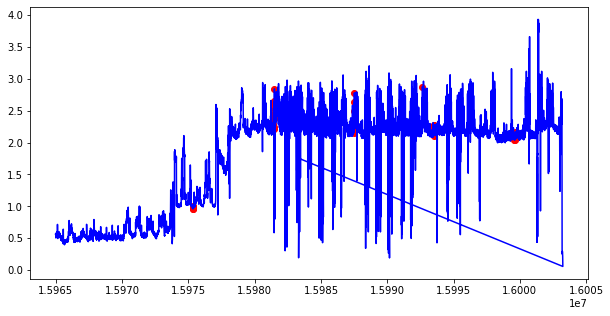

In [68]:
fig, ax = plt.subplots()
a = df.loc[df['anomaly21'] == 1, ['time_epoch', 'cpu']] #anomaly

ax.plot(df['time_epoch'], df['cpu'], color = 'blue')
ax.scatter(a['time_epoch'], a['cpu'], color = 'red')
plt.show()

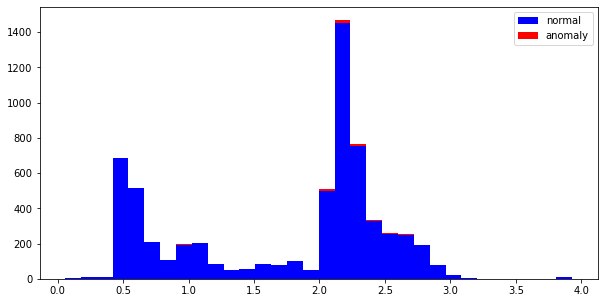

In [69]:
a = df.loc[df['anomaly21'] == 0, 'cpu']
b = df.loc[df['anomaly21'] == 1, 'cpu']

fig, axs = plt.subplots()
axs.hist([a, b], bins=32, stacked=True, color=['blue', 'red'], label = ['normal', 'anomaly'])
plt.legend()
plt.show()

## Categories + Gaussian

In [70]:
# creation of 4 differents data set based on categories defined before
df_class0 = df.loc[df['categories'] == 0, 'cpu']
df_class1 = df.loc[df['categories'] == 1, 'cpu']
df_class2 = df.loc[df['categories'] == 2, 'cpu']
df_class3 = df.loc[df['categories'] == 3, 'cpu']

<AxesSubplot:>

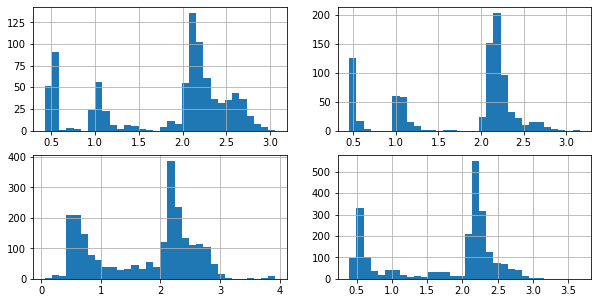

In [71]:
# plot the temperature repartition by categories
fig, axs = plt.subplots(2,2)
df_class0.hist(ax=axs[0,0],bins=32)
df_class1.hist(ax=axs[0,1],bins=32)
df_class2.hist(ax=axs[1,0],bins=32)
df_class3.hist(ax=axs[1,1],bins=32)

In [72]:
envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class0.values.reshape(-1,1)
envelope.fit(X_train)
df_class0 = pd.DataFrame(df_class0)
df_class0['deviation'] = envelope.decision_function(X_train)
df_class0['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class1.values.reshape(-1,1)
envelope.fit(X_train)
df_class1 = pd.DataFrame(df_class1)
df_class1['deviation'] = envelope.decision_function(X_train)
df_class1['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class2.values.reshape(-1,1)
envelope.fit(X_train)
df_class2 = pd.DataFrame(df_class2)
df_class2['deviation'] = envelope.decision_function(X_train)
df_class2['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class3.values.reshape(-1,1)
envelope.fit(X_train)
df_class3 = pd.DataFrame(df_class3)
df_class3['deviation'] = envelope.decision_function(X_train)
df_class3['anomaly'] = envelope.predict(X_train)

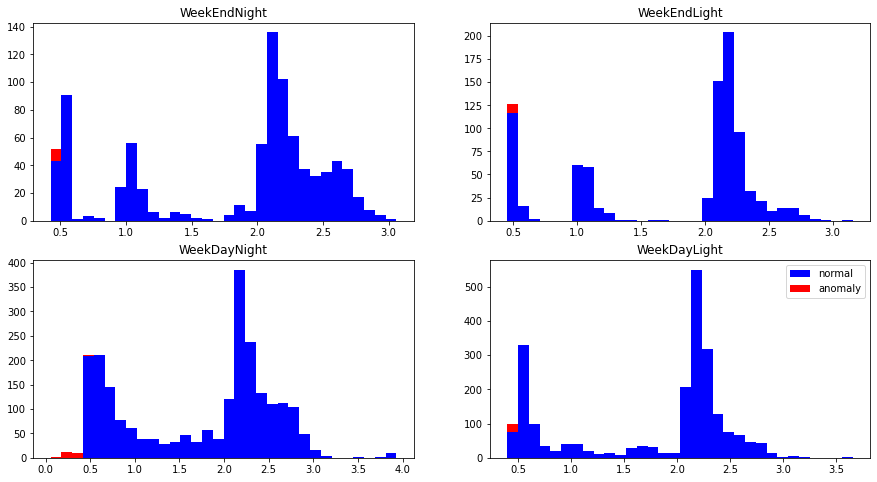

In [73]:
# plot the temperature repartition by categories with anomalies
a0 = df_class0.loc[df_class0['anomaly'] == 1, 'cpu']
b0 = df_class0.loc[df_class0['anomaly'] == -1, 'cpu']

a1 = df_class1.loc[df_class1['anomaly'] == 1, 'cpu']
b1 = df_class1.loc[df_class1['anomaly'] == -1, 'cpu']

a2 = df_class2.loc[df_class2['anomaly'] == 1, 'cpu']
b2 = df_class2.loc[df_class2['anomaly'] == -1, 'cpu']

a3 = df_class3.loc[df_class3['anomaly'] == 1, 'cpu']
b3 = df_class3.loc[df_class3['anomaly'] == -1, 'cpu']

plt.rcParams['figure.figsize'] = [15, 8]
fig, axs = plt.subplots(2,2)
axs[0,0].hist([a0,b0], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[0,1].hist([a1,b1], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[1,0].hist([a2,b2], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[1,1].hist([a3,b3], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[0,0].set_title("WeekEndNight")
axs[0,1].set_title("WeekEndLight")
axs[1,0].set_title("WeekDayNight")
axs[1,1].set_title("WeekDayLight")
plt.legend()
plt.show()

In [74]:
df_class = pd.concat([df_class0, df_class1, df_class2, df_class3])
df['anomaly22'] = df_class['anomaly']
df['anomaly22'] = np.array(df['anomaly22'] == -1).astype(float)

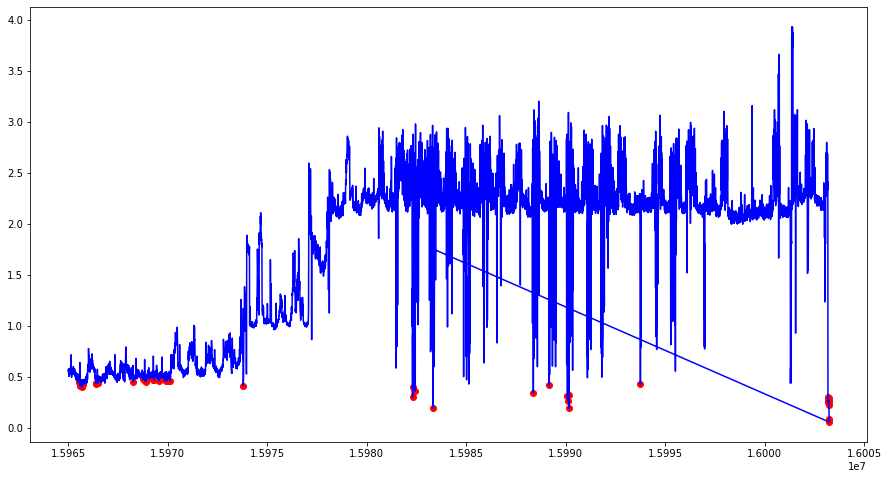

In [75]:
fig, ax = plt.subplots()

a = df.loc[df['anomaly22'] == 1, ('time_epoch', 'cpu')] #anomaly

ax.plot(df['time_epoch'], df['cpu'], color='blue')
ax.scatter(a['time_epoch'], a['cpu'], color='red')
plt.show()

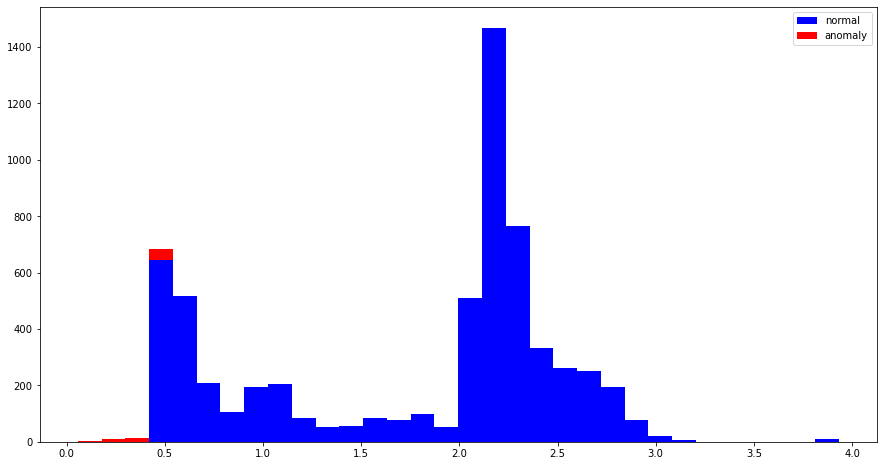

In [76]:
a = df.loc[df['anomaly22'] == 0, 'cpu']
b = df.loc[df['anomaly22'] == 1, 'cpu']

fig, axs = plt.subplots()
axs.hist([a, b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

## Markov chains

In [77]:
x1 = (df['cpu'] <= 18).astype(int)
x2 = ((df['cpu'] > 18) & (df['cpu'] <= 21)).astype(int)
x3 = ((df['cpu'] > 21) & (df['cpu'] <= 24)).astype(int)
x4 = ((df['cpu'] > 24) & (df['cpu'] <= 27)).astype(int)
x5 = (df['cpu'] > 27).astype(int)
df_mm = x1 + 2*x2 + 3*x3 + 4*x4 + 5*x5
print(df_mm)


0       1
1       1
2       1
3       1
4       1
       ..
6344    1
6345    1
6346    1
6347    1
6348    1
Name: cpu, Length: 6349, dtype: int64


## Isolation Forest

In [78]:
data = df[['cpu', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train isolation forest 
model =  IsolationForest(contamination = outliers_fraction)
model.fit(data)
# add the data to the main  
df['anomaly25'] = pd.Series(model.predict(data))
df['anomaly25'] = df['anomaly25'].map( {1: 0, -1: 1} )
print(df['anomaly25'].value_counts())

0    6285
1      64
Name: anomaly25, dtype: int64


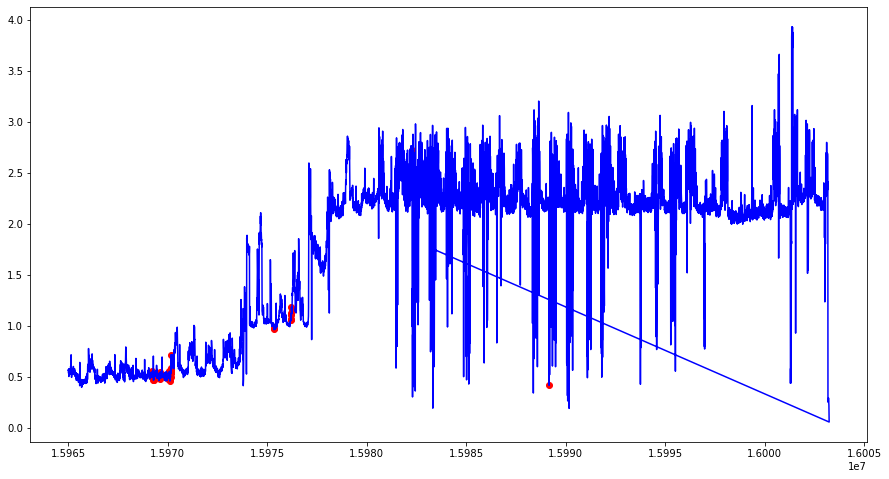

In [79]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly25'] == 1, ['time_epoch', 'cpu']] #anomaly

ax.plot(df['time_epoch'], df['cpu'], color='blue')
ax.scatter(a['time_epoch'],a['cpu'], color='red')
plt.show()

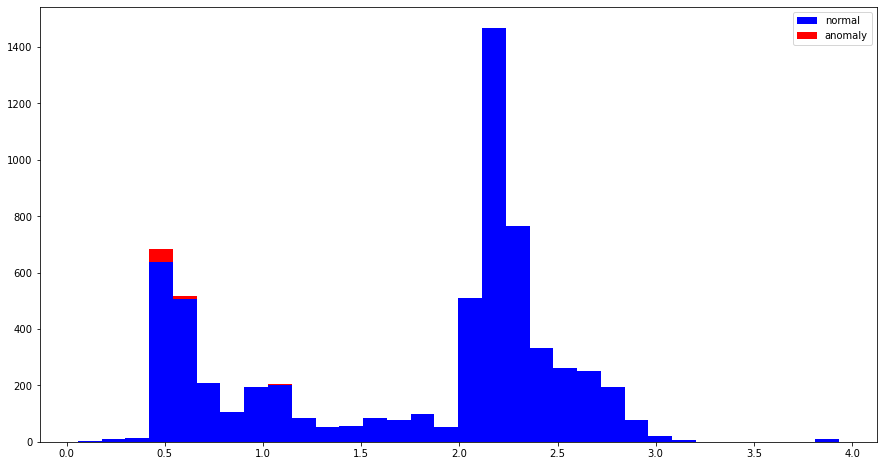

In [80]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly25'] == 0, 'cpu']
b = df.loc[df['anomaly25'] == 1, 'cpu']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label = ['normal', 'anomaly'])
plt.legend()
plt.show()

## One class SVM

In [81]:
# Take useful feature and standardize them 
data = df[['cpu', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
# train one class SVM 
model =  OneClassSVM(nu=0.95 * outliers_fraction) #nu=0.95 * outliers_fraction  + 0.05
data = pd.DataFrame(np_scaled)
model.fit(data)
# add the data to the main  
df['anomaly26'] = pd.Series(model.predict(data))
df['anomaly26'] = df['anomaly26'].map( {1: 0, -1: 1} )
print(df['anomaly26'].value_counts())

0    6287
1      62
Name: anomaly26, dtype: int64


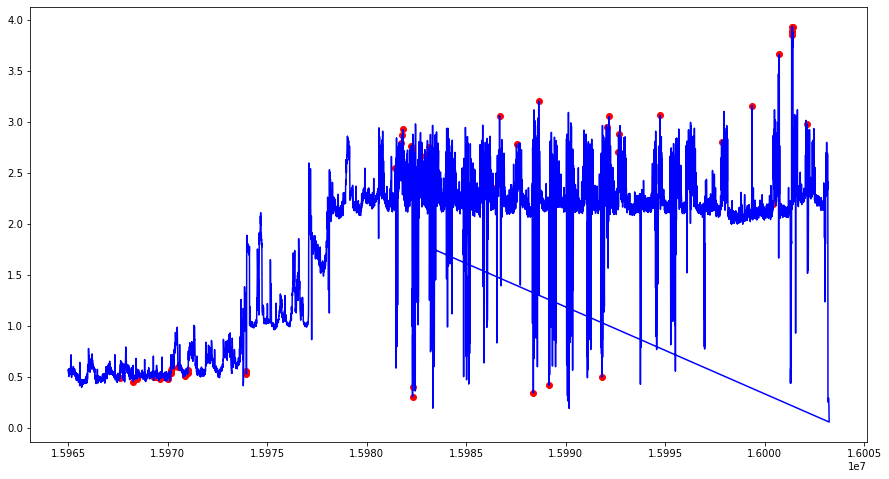

In [82]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly26'] == 1, ['time_epoch', 'cpu']] #anomaly

ax.plot(df['time_epoch'], df['cpu'], color='blue')
ax.scatter(a['time_epoch'],a['cpu'], color='red')
plt.show()

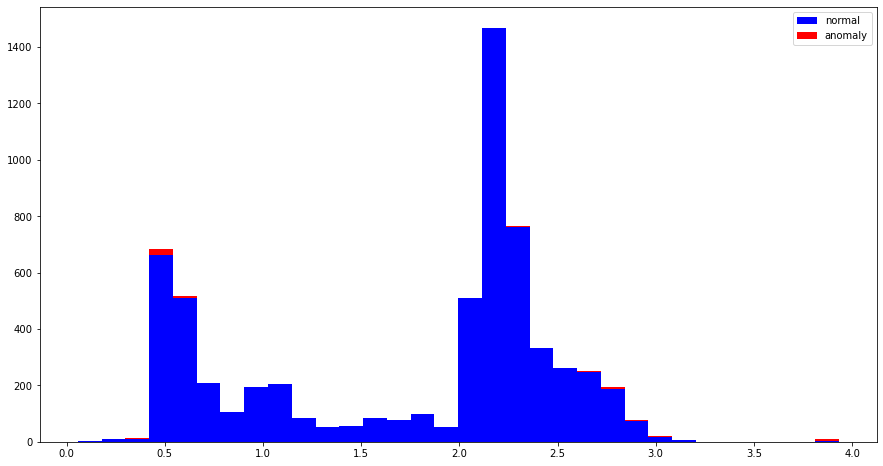

In [83]:
a = df.loc[df['anomaly26'] == 0, 'cpu']
b = df.loc[df['anomaly26'] == 1, 'cpu']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

# RNN

In [84]:
#select and standardize data
data_n = df[['cpu', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data_n)
data_n = pd.DataFrame(np_scaled)

# important parameters and train/test size
prediction_time = 1 
testdatasize = 1000
unroll_length = 50
testdatacut = testdatasize + unroll_length  + 1

#total_row = data_n.index.stop
#prediction_time = 1 
#testdatasize = int(total_row - (total_row * 0.95))
#unroll_length = int(total_row * 0.05)
#testdatacut = testdatasize + unroll_length + 1

x_train = data_n[0:-prediction_time-testdatacut].values
y_train = data_n[prediction_time:-testdatacut][0].values


# test data
x_test = data_n[0-testdatacut:-prediction_time].values
y_test = data_n[prediction_time-testdatacut:  ][0].values


In [85]:
def unroll(data,sequence_length=24):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)

# adapt the datasets for the sequence data shape
x_train = unroll(x_train,unroll_length)
x_test  = unroll(x_test,unroll_length)
y_train = y_train[-x_train.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]

# see the shape
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (5247, 50, 5)
y_train (5247,)
x_test (1000, 50, 5)
y_test (1000,)


In [86]:
# specific libraries for RNN
# keras is a high layer build on Tensorflow layer to stay in high level/easy implementation
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time #helper libraries
from keras.models import model_from_json
import sys

In [87]:
### CJB : 파라미터 다시 확인 후 조절할 것

# Build the model
model = Sequential()
model.add(LSTM(100, input_shape = (50, 5), return_sequences = True)) 
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mean_squared_error', optimizer='rmsprop')
model.summary()
print('compilation time : {}'.format(time.time() - start))


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50, 100)           42400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 122,901
Trainable params: 122,901
Non-trainable params: 0
________________________________________________

In [88]:
model.fit(x_train, y_train, batch_size=128, epochs=500, validation_split=0.1)

Epoch 1/500
37/37 [==============================] - 8s 211ms/step - loss: 0.2241 - val_loss: 0.1428
Epoch 2/500
37/37 [==============================] - 7s 198ms/step - loss: 0.1703 - val_loss: 0.1437
Epoch 3/500
37/37 [==============================] - 7s 189ms/step - loss: 0.1603 - val_loss: 0.1367
Epoch 4/500
37/37 [==============================] - 7s 195ms/step - loss: 0.1567 - val_loss: 0.1351
Epoch 5/500
37/37 [==============================] - 7s 189ms/step - loss: 0.1535 - val_loss: 0.1367
Epoch 6/500
37/37 [==============================] - 7s 189ms/step - loss: 0.1517 - val_loss: 0.1367
Epoch 7/500
37/37 [==============================] - 7s 188ms/step - loss: 0.1485 - val_loss: 0.1317
Epoch 8/500
37/37 [==============================] - 8s 206ms/step - loss: 0.1475 - val_loss: 0.1388
Epoch 9/500
37/37 [==============================] - 7s 194ms/step - loss: 0.1478 - val_loss: 0.1361
Epoch 10/500
37/37 [==============================] - 7s 193ms/step - loss: 0.1445 - val_lo

37/37 [==============================] - 7s 194ms/step - loss: 0.0860 - val_loss: 0.2958
Epoch 82/500
37/37 [==============================] - 7s 192ms/step - loss: 0.0862 - val_loss: 0.2550
Epoch 83/500
37/37 [==============================] - 8s 207ms/step - loss: 0.0857 - val_loss: 0.2357
Epoch 84/500
37/37 [==============================] - 7s 191ms/step - loss: 0.0839 - val_loss: 0.2138
Epoch 85/500
37/37 [==============================] - 7s 192ms/step - loss: 0.0853 - val_loss: 0.2099
Epoch 86/500
37/37 [==============================] - 7s 189ms/step - loss: 0.0807 - val_loss: 0.2511
Epoch 87/500
37/37 [==============================] - 7s 188ms/step - loss: 0.0849 - val_loss: 0.2321
Epoch 88/500
37/37 [==============================] - 7s 192ms/step - loss: 0.0817 - val_loss: 0.2250
Epoch 89/500
37/37 [==============================] - 7s 188ms/step - loss: 0.0810 - val_loss: 0.2531
Epoch 90/500
37/37 [==============================] - 7s 192ms/step - loss: 0.0788 - val_loss: 

Epoch 161/500
37/37 [==============================] - 7s 184ms/step - loss: 0.0470 - val_loss: 0.2659
Epoch 162/500
37/37 [==============================] - 7s 197ms/step - loss: 0.0457 - val_loss: 0.2199
Epoch 163/500
37/37 [==============================] - 7s 192ms/step - loss: 0.0454 - val_loss: 0.2361
Epoch 164/500
37/37 [==============================] - 7s 191ms/step - loss: 0.0445 - val_loss: 0.2448
Epoch 165/500
37/37 [==============================] - 7s 186ms/step - loss: 0.0474 - val_loss: 0.2421
Epoch 166/500
37/37 [==============================] - 8s 207ms/step - loss: 0.0439 - val_loss: 0.2344
Epoch 167/500
37/37 [==============================] - 7s 194ms/step - loss: 0.0426 - val_loss: 0.2409
Epoch 168/500
37/37 [==============================] - 7s 191ms/step - loss: 0.0436 - val_loss: 0.2415
Epoch 169/500
37/37 [==============================] - 7s 189ms/step - loss: 0.0427 - val_loss: 0.2650
Epoch 170/500
37/37 [==============================] - 7s 194ms/step - lo

37/37 [==============================] - 7s 194ms/step - loss: 0.0273 - val_loss: 0.2580
Epoch 241/500
37/37 [==============================] - 8s 208ms/step - loss: 0.0275 - val_loss: 0.2396
Epoch 242/500
37/37 [==============================] - 7s 201ms/step - loss: 0.0263 - val_loss: 0.2508
Epoch 243/500
37/37 [==============================] - 7s 191ms/step - loss: 0.0281 - val_loss: 0.2353
Epoch 244/500
37/37 [==============================] - 7s 195ms/step - loss: 0.0283 - val_loss: 0.2434
Epoch 245/500
37/37 [==============================] - 7s 194ms/step - loss: 0.0270 - val_loss: 0.2294
Epoch 246/500
37/37 [==============================] - 7s 192ms/step - loss: 0.0279 - val_loss: 0.2542
Epoch 247/500
37/37 [==============================] - 7s 191ms/step - loss: 0.0264 - val_loss: 0.2616
Epoch 248/500
37/37 [==============================] - 7s 192ms/step - loss: 0.0276 - val_loss: 0.2601
Epoch 249/500
37/37 [==============================] - 8s 210ms/step - loss: 0.0256 - v

37/37 [==============================] - 7s 197ms/step - loss: 0.0181 - val_loss: 0.2681
Epoch 320/500
37/37 [==============================] - 7s 195ms/step - loss: 0.0191 - val_loss: 0.2660
Epoch 321/500
37/37 [==============================] - 7s 192ms/step - loss: 0.0192 - val_loss: 0.2635
Epoch 322/500
37/37 [==============================] - 7s 197ms/step - loss: 0.0193 - val_loss: 0.2524
Epoch 323/500
37/37 [==============================] - 7s 191ms/step - loss: 0.0197 - val_loss: 0.2473
Epoch 324/500
37/37 [==============================] - 8s 222ms/step - loss: 0.0189 - val_loss: 0.2791
Epoch 325/500
37/37 [==============================] - 7s 195ms/step - loss: 0.0191 - val_loss: 0.2542
Epoch 326/500
37/37 [==============================] - 7s 195ms/step - loss: 0.0203 - val_loss: 0.2851
Epoch 327/500
37/37 [==============================] - 7s 189ms/step - loss: 0.0191 - val_loss: 0.2953
Epoch 328/500
37/37 [==============================] - 7s 196ms/step - loss: 0.0183 - v

37/37 [==============================] - 7s 190ms/step - loss: 0.0151 - val_loss: 0.2478
Epoch 399/500
37/37 [==============================] - 8s 210ms/step - loss: 0.0155 - val_loss: 0.2394
Epoch 400/500
37/37 [==============================] - 7s 187ms/step - loss: 0.0154 - val_loss: 0.2222
Epoch 401/500
37/37 [==============================] - 7s 194ms/step - loss: 0.0151 - val_loss: 0.2314
Epoch 402/500
37/37 [==============================] - 7s 186ms/step - loss: 0.0167 - val_loss: 0.2093
Epoch 403/500
37/37 [==============================] - 7s 193ms/step - loss: 0.0161 - val_loss: 0.2289
Epoch 404/500
37/37 [==============================] - 7s 188ms/step - loss: 0.0157 - val_loss: 0.2304
Epoch 405/500
37/37 [==============================] - 7s 186ms/step - loss: 0.0150 - val_loss: 0.2600
Epoch 406/500
37/37 [==============================] - 7s 185ms/step - loss: 0.0160 - val_loss: 0.2549
Epoch 407/500
37/37 [==============================] - 8s 203ms/step - loss: 0.0158 - v

37/37 [==============================] - 7s 191ms/step - loss: 0.0124 - val_loss: 0.2427
Epoch 478/500
37/37 [==============================] - 7s 188ms/step - loss: 0.0131 - val_loss: 0.2356
Epoch 479/500
37/37 [==============================] - 7s 191ms/step - loss: 0.0131 - val_loss: 0.2151
Epoch 480/500
37/37 [==============================] - 7s 188ms/step - loss: 0.0133 - val_loss: 0.2508
Epoch 481/500
37/37 [==============================] - 7s 186ms/step - loss: 0.0130 - val_loss: 0.2380
Epoch 482/500
37/37 [==============================] - 7s 194ms/step - loss: 0.0138 - val_loss: 0.2556
Epoch 483/500
37/37 [==============================] - 8s 206ms/step - loss: 0.0127 - val_loss: 0.2581
Epoch 484/500
37/37 [==============================] - 7s 187ms/step - loss: 0.0128 - val_loss: 0.2368
Epoch 485/500
37/37 [==============================] - 7s 187ms/step - loss: 0.0126 - val_loss: 0.2476
Epoch 486/500
37/37 [==============================] - 7s 191ms/step - loss: 0.0123 - v

In [89]:
loaded_model = model
diff=[]
ratio=[]
p = loaded_model.predict(x_test)
# predictions = lstm.predict_sequences_multiple(loaded_model, x_test, 50, 50)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))

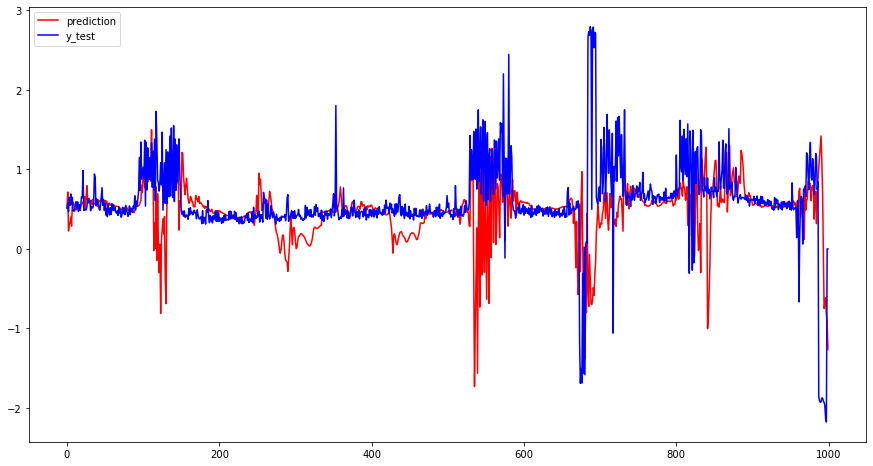

In [90]:
fig, axs = plt.subplots()
axs.plot(p,color='red', label='prediction')
axs.plot(y_test,color='blue', label='y_test')
plt.legend(loc='upper left')
plt.show()